# Laboratorium 01 — Wprowadzenie do analizy obrazów medycznych (DICOM i NIfTI)

W tym laboratorium rozpoczniemy pracę z medycznymi danymi obrazowymi. Poznamy podstawowe formaty (DICOM, NIfTI), sposoby wczytywania i eksploracji wolumenów 3D, przegląd najważniejszych metadanych oraz wykonamy proste przekształcenia i wizualizacje.

## Cele nauczania
- Zrozumienie różnic między formatami DICOM i NIfTI oraz kiedy ich używać.
- Wczytywanie obrazów z użyciem bibliotek: pydicom, SimpleITK, nibabel, nilearn.
- Odczyt i interpretacja metadanych.
- Podstawowe operacje na danych 3D: wybór przekrojów, progowanie, obliczanie gradientów (Sobel), przepróbkowanie (interpolacja danych).
- Przegląd i zapis danych do plików NIfTI.

## Zakres i przepływ pracy
1. DICOM: wczytanie pojedynczych plików, przegląd nagłówka i pikseli (pydicom, SimpleITK)
2. NIfTI: wczytanie wolumenu, macierz affine, orientacje, podstawowe przekroje (nibabel)
3. Wizualizacja 2D/3D: przekroje osiowe/koronalne/strzałkowe, proste układy figur (matplotlib, opcjonalnie nilearn)
4. Proste przekształcenia: progowanie, filtr Sobela 3D, filtracja medianowa
5. Resamplowanie i zapis: izotropizacja voxeli, zapis przetworzonych danych do NIfTI

## Dane do ćwiczeń
Dane powinny pobrać się automatycznie w ramach skryptu. Znajdują się one w folderze data lub /content/data (w przypadku Google Colab).

## Wymagane narzędzia i biblioteki
- Python 3.9+ oraz:
  - numpy, matplotlib
  - pydicom, SimpleITK
  - nibabel, nilearn
- Biblioteki należy zainstalować na początku skryptu jeśli pracujesz w Google Colab. Jeśli pracujesz lokalnie, to warto stworzyć środowisko conda lub venv.

## Typowe pułapki i wskazówki
- Orientacje i układy współrzędnych: DICOM zwykle używa LPS, wiele narzędzi neuro (nibabel/nilearn) preferuje RAS. Nie mieszaj konwencji bez kontroli affine.
- Jednostki i skale intensywności: CT (HU - Hounsfield Units) vs MR (wartości względne). Normalizuj lub standaryzuj dane przed progowaniem/filtracją.
- Spójny spacing: przed analizą porównawczą rozważ resamplowanie do voxeli izotropowych (np. 1×1×1 mm).
- Pamięć i wydajność: pracujemy na małych przykładach, ale na większych danych stosuje się lazy loading (dane nie są wczytywane od razu, tylko po wywołaniu), ogranicza rozmiar figur i liczbę kopii tablic.

Powodzenia! W kolejnych sekcjach przejdziemy od wczytania plików po zapis przetworzonych wolumenów i krótką analizę.

## 0) Instalacja bibliotek (jeśli potrzebne)

In [2]:
# Uruchom, jeśli pojawi się błąd 'ModuleNotFoundError'
#!pip -q install scipy nibabel nilearn SimpleITK pydicom matplotlib numpy


## 1) Automatyczne pobranie przykładowych danych

Aby nie trzeba było samodzielnie uploadować danych, wczytamy:
- **DICOM**: przykładowe pliki z pakietu `pydicom` (CT, MR),
- **NIfTI**: mały wolumen MNI152 (szablon MRI mózgu) pobrany z `nilearn`.


In [3]:
import os, shutil, urllib.request
import numpy as np
import matplotlib.pyplot as plt

import nibabel as nib
import SimpleITK as sitk
import pydicom
from pydicom.data import get_testdata_files

from scipy import ndimage as ndi

BASE = "/content/data" if os.path.isdir("/content") else "./data"
DATA_DIR = os.path.join(BASE, "/home/patryk/Desktop/AiR_ISS/sem2/PIAOM/lab1/lab01_data")
os.makedirs(DATA_DIR, exist_ok=True)

# --- DICOM ---
dicom_dir = os.path.join(DATA_DIR, "dicom")
os.makedirs(dicom_dir, exist_ok=True)

dicom_examples = ["CT_small.dcm", "MR_small.dcm", "SC_rgb.dcm"]
for name in dicom_examples:
    src = get_testdata_files(name)[0]
    dst = os.path.join(dicom_dir, name)
    shutil.copy(src, dst)
print("Skopiowano pliki DICOM:", os.listdir(dicom_dir))

# --- NIfTI ---
nifti_dir = os.path.join(DATA_DIR, "nifti")
os.makedirs(nifti_dir, exist_ok=True)

nifti_path = os.path.join(nifti_dir, "mni152.nii.gz")
try:
    from nilearn.datasets import load_mni152_template
    img = load_mni152_template(resolution=2)
    nib.save(img, nifti_path)
    print("Pobrano MNI152 przez nilearn:", nifti_path)
except Exception as e:
    print("Błąd nilearn:", e)
    url = "https://nipy.org/nibabel/_static/nifti_examples/nifti1.nii.gz"
    urllib.request.urlretrieve(url, nifti_path)
    print("Pobrano fallback NIfTI:", nifti_path)

print("Gotowe dane w:", DATA_DIR)


Skopiowano pliki DICOM: ['MR_small.dcm', 'CT_small.dcm', 'SC_rgb.dcm']
Pobrano MNI152 przez nilearn: /home/patryk/Desktop/AiR_ISS/sem2/PIAOM/lab1/lab01_data/nifti/mni152.nii.gz
Gotowe dane w: /home/patryk/Desktop/AiR_ISS/sem2/PIAOM/lab1/lab01_data



## Zadanie 1 – Wczytanie obrazu DICOM i metadane

1. Wykonaj ponizsze operacje dla każdego z pobranych plików testowych DICOM (nazwy w `dicom_examples`).
2. Metadane mogą być wczytane zarówno za pomocą biblioteki `pydicom` jak i `SimpleITK`.
3. Najpierw wczytaj plik za pomocą funkcji `pydicom.dcmread`.
4. Następnie wczytaj i wyświetl za pomocą funkcji `getattr` metadane takie jak: `"Modality", "Rows", "Columns", "PixelSpacing", "SliceThickness", "Manufacturer"`.
Przykład wczytania przykładowej wartości: `print("Photometric Interpretation:", getattr(img_dcm_pydicom, "PhotometricInterpretation", "brak"))`.
5. Wczytaj ten sam plik za pomocą funkcji `sitk.ReadImage`.
6. Wypisz wszystkie dostępne metadane dostępne w plikach. W tym celu wykorzystaj funkcji `img.GetMetaDataKeys()` oraz `img_dcm.GetMetaData(key)`.
7. Przeanalizuj dostępne metadane.
8. Wczytaj dane obrazowe za pomocą funkcji `sitk.GetArrayFromImage`, a następnie wyświetl dane za pomocą `matplotlib`.

----- pydicom -------
CT
128
128
[0.661468, 0.661468]
5.000000
GE MEDICAL SYSTEMS

----- sitk ------
('0008|0005', '0008|0008', '0008|0012', '0008|0013', '0008|0014', '0008|0016', '0008|0018', '0008|0020', '0008|0021', '0008|0022', '0008|0023', '0008|0030', '0008|0031', '0008|0032', '0008|0033', '0008|0050', '0008|0060', '0008|0070', '0008|0080', '0008|0090', '0008|0201', '0008|1010', '0008|1030', '0008|1090', '0010|0010', '0010|0020', '0010|0030', '0010|0040', '0010|1010', '0010|1030', '0010|21b0', '0018|0010', '0018|0022', '0018|0050', '0018|0060', '0018|0088', '0018|0090', '0018|1020', '0018|1040', '0018|1100', '0018|1110', '0018|1111', '0018|1120', '0018|1130', '0018|1150', '0018|1151', '0018|1152', '0018|1160', '0018|1190', '0018|1210', '0018|5100', '0020|000d', '0020|000e', '0020|0010', '0020|0011', '0020|0012', '0020|0013', '0020|0032', '0020|0037', '0020|0052', '0020|0060', '0020|1040', '0020|1041', '0020|4000', '0028|0002', '0028|0004', '0028|0010', '0028|0011', '0028|0030', '

(np.float64(-0.5), np.float64(127.5), np.float64(127.5), np.float64(-0.5))

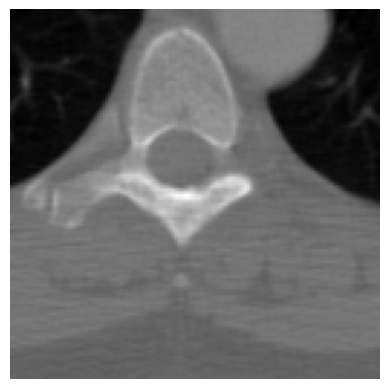

In [4]:
path_example = r"/home/patryk/Desktop/AiR_ISS/sem2/PIAOM/lab1/lab01_data/dicom/CT_small.dcm"
img = pydicom.dcmread(path_example)

print("----- pydicom -------")
print(getattr(img, "Modality"))
print(getattr(img, "Rows"))
print(getattr(img, "Columns"))
print(getattr(img, "PixelSpacing"))
print(getattr(img, "SliceThickness"))
print(getattr(img, "Manufacturer"))

print()

print("----- sitk ------")
img = sitk.ReadImage(path_example)

print(img.GetMetaDataKeys())

plt.imshow(np.squeeze(sitk.GetArrayFromImage(img), axis=0), cmap="gray")
plt.axis(False)

In [5]:
# --- Zadanie 1

# paths = [os.path.join(root, file)
#          for root, dirs, files in os.walk(r"/home/patryk/Desktop/AiR_ISS/sem2/PIAOM/lab1/lab01_data/dicom")
#          for file in files]

# for path in paths:
#     img = pydicom.dcmread(path)
    


## Zadanie 2 – Wczytanie wolumenu NIfTI i przekroje

1. Wczytaj plik `mni152.nii.gz`. Ścieżka znajduje się w `nifti_path`. Wykorzystaj funkcję `nib.load`.
2. Wczytaj dane za pomocą funkcji `file.get_fdata()`.
3. Sprawdź kształt tablicy (`data.shape`), macierz affine (`file.affine`), spacing (`file.header.get_zooms()`) oraz kierunek osi `nib.aff2axcodes(nii.affine)`.
4. Wyświetl trzy środkowe przekroje: axial (poprzeczny - "od góry"), coronal (czołowy - "od przodu"), sagittal (strzałkowy - "od boku").


(99, 117, 95)
[[   2.    0.    0.  -98.]
 [   0.    2.    0. -134.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]]
(np.float32(2.0), np.float32(2.0), np.float32(2.0))
('R', 'A', 'S')


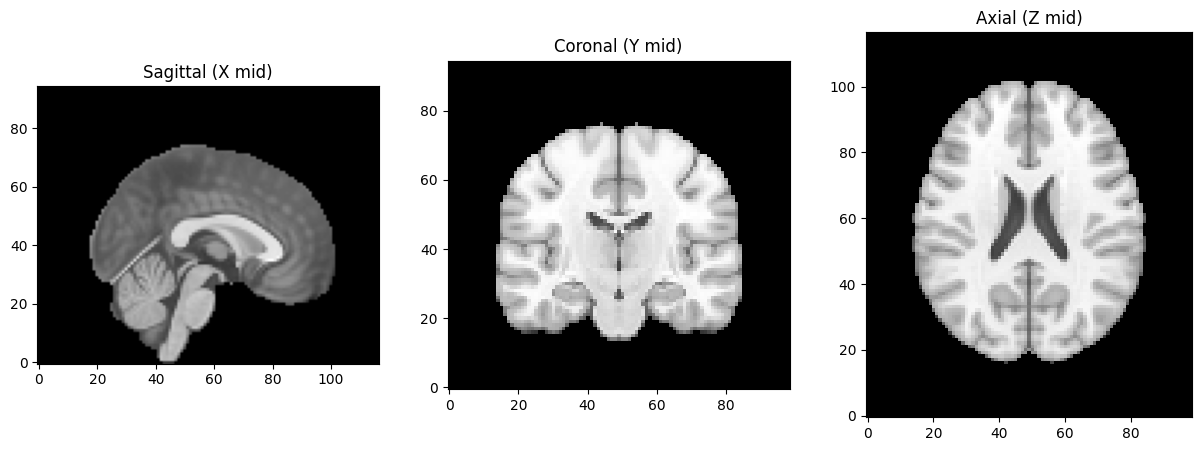

In [6]:
# --- Zadanie 2

path_example = r"/home/patryk/Desktop/AiR_ISS/sem2/PIAOM/lab1/lab01_data/nifti/mni152.nii.gz"
file = nib.load(path_example)
data = file.get_fdata()

print(data.shape)
print(file.affine)
print(file.header.get_zooms())
print(nib.aff2axcodes(file.affine))

x, y, z = data.shape

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Sagittal
axes[0].imshow(data[x//2, :, :].T, cmap="gray", origin="lower")
axes[0].set_title("Sagittal (X mid)")

# Coronal
axes[1].imshow(data[:, y//2, :].T, cmap="gray", origin="lower")
axes[1].set_title("Coronal (Y mid)")

# Axial
axes[2].imshow(data[:, :, z//2].T, cmap="gray", origin="lower")
axes[2].set_title("Axial (Z mid)")

plt.show()



## Zadanie 3 – Histogram i podstawowe operacje

1. Wyświetl histogram intensywności wolumenu (NIfTI) za pomocą funkcji `plt.hist`. W celu poprawy widoczności można ustawić `range=(0.01, 1)`. Wcześniej spłaszcz dane za pomocą metody `.ravel()`.
2. Wyświetl 3 oryginalne przekroje (jak w poprzednim zadaniu).
3. Oblicz gradient Sobela względem wszystkich trzech osi. Wykorzystaj funkcję `ndi.sobel`.
4. Za pomocą normy L2 połącz wyniki z wszystkich osi.
5. Wyświetl te same przekroje jak wcześniej.
6. Wykonaj progowanie dla 90-tego precentyla danych. Do wyznaczenia tej wartości wykorzystaj funkcję `np.percentile`.
7. Wykonaj progowania, a następnie zrzutuj wynik do typu `np.uint8`.
8. Wyświetl te same przekroje jak wcześniej.
9. Wykonaj filtrację medianową dla tych samych danych. Wykorzystaj funkcję `ndi.median_filter`.
10. Wyświetl te same przekroje jak wcześniej.


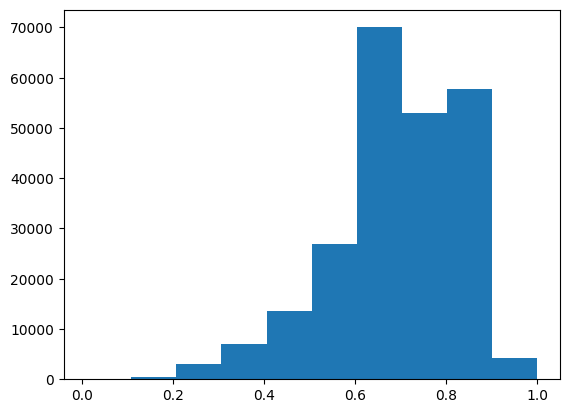

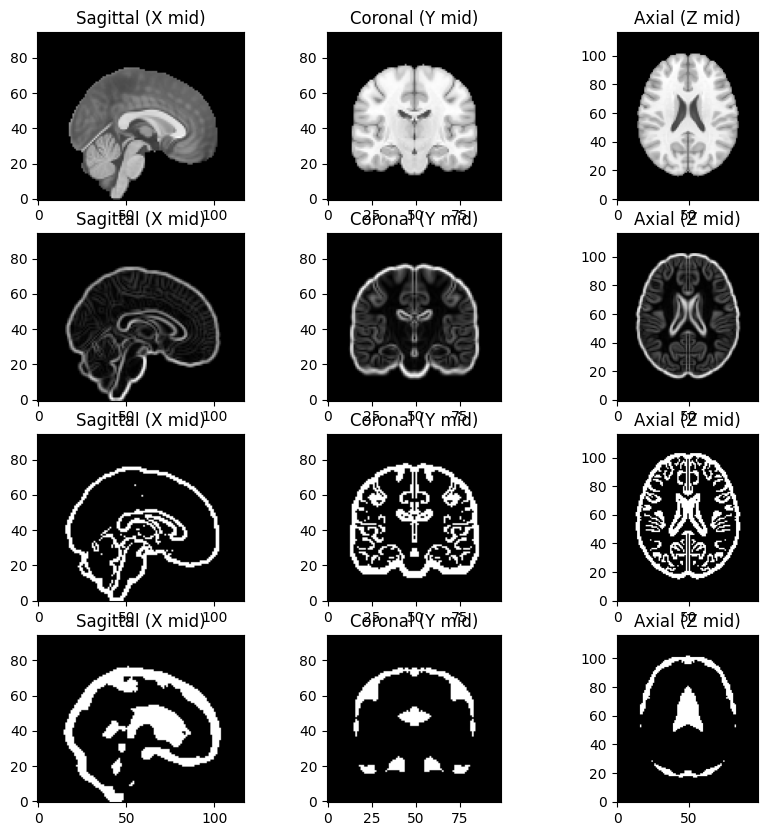

In [7]:
# --- Zadanie 3
plt.hist(data.ravel(), range=(0.01, 1))

# gradient Sobla
grad_x = ndi.sobel(data, axis=0)
grad_y = ndi.sobel(data, axis=1)
grad_z = ndi.sobel(data, axis=2)

grad_mag = np.sqrt(grad_x**2+grad_y**2+grad_z**2)

# progowanie
tresh = np.percentile(grad_mag, 90)
binary_mask = grad_mag > tresh

# filtracja medianowa
median = ndi.median_filter(binary_mask, size=7)


fig, axes = plt.subplots(4, 3, figsize=(10, 10))

# Sagittal
axes[0][0].imshow(data[x//2, :, :].T, cmap="gray", origin="lower")
axes[0][0].set_title("Sagittal (X mid)")

# Coronal
axes[0][1].imshow(data[:, y//2, :].T, cmap="gray", origin="lower")
axes[0][1].set_title("Coronal (Y mid)")

# Axial
axes[0][2].imshow(data[:, :, z//2].T, cmap="gray", origin="lower")
axes[0][2].set_title("Axial (Z mid)")

axes[1][0].imshow(grad_mag[x//2, :, :].T, cmap="gray", origin="lower")
axes[1][0].set_title("Sagittal (X mid)")

# Coronal
axes[1][1].imshow(grad_mag[:, y//2, :].T, cmap="gray", origin="lower")
axes[1][1].set_title("Coronal (Y mid)")

# Axial
axes[1][2].imshow(grad_mag[:, :, z//2].T, cmap="gray", origin="lower")
axes[1][2].set_title("Axial (Z mid)")

axes[2][0].imshow(binary_mask[x//2, :, :].T, cmap="gray", origin="lower")
axes[2][0].set_title("Sagittal (X mid)")

# Coronal
axes[2][1].imshow(binary_mask[:, y//2, :].T, cmap="gray", origin="lower")
axes[2][1].set_title("Coronal (Y mid)")

# Axial
axes[2][2].imshow(binary_mask[:, :, z//2].T, cmap="gray", origin="lower")
axes[2][2].set_title("Axial (Z mid)")

axes[3][0].imshow(median[x//2, :, :].T, cmap="gray", origin="lower")
axes[3][0].set_title("Sagittal (X mid)")

# Coronal
axes[3][1].imshow(median[:, y//2, :].T, cmap="gray", origin="lower")
axes[3][1].set_title("Coronal (Y mid)")

# Axial
axes[3][2].imshow(median[:, :, z//2].T, cmap="gray", origin="lower")
axes[3][2].set_title("Axial (Z mid)")


plt.show()



## Zadanie 4 – Resampling wolumenu do izotropowego voxela

1. Wczytaj dane NIfTI za pomocą `SimpleITK`. Wykorzystaj funkcję `sitk.ReadImage`.
2. Wyświetl rozmiar i spacing wczytanych danych. Wykorzystaj metody `.GetSize()` i `.GetSpacing()`.
3. Stwórz instancję klasy `sitk.ResampleImageFilter()`.
4. Wybierz metodę interpolacji za pomocą metody `.SetInterpolator`.
5. Wybierz wyjściowy spacing za pomocą metody `.SetOutputSpacing`. Chcemy uzyskać spacing 1mm dla każdej osi.
6. Ustaw orientację i położenie początka ukłądu współrzędnych jak w oryginalnych danych. Wykorzystaj metody `.SetOutputDirection`, `.GetDirection`, `.SetOutputOrigin` i `.GetOrigin`.
7. Oblicz rozmiar wyjściowych danych. Rozmiar dla analizowanego wymiaru powinien wynosić $Sz_o \cdot Sp_o / Sp_n$, gdzie $Sz_o$ jest originalnym rozmiarem, $Sp_o$ jest oryginalnym spacingiem, a $Sp_n$ jest docelowym spacingiem.
8. Ustaw docelowy rozmiar za pomocą metody `.SetSize`.
9. Wykonaj przeprobkowanie danych za pomocą metody `.Execute`.
10. Wyświetl rozmiar oraz spacing wyjściowych danych.

In [8]:
# --- Zadanie 4

img = sitk.ReadImage(path_example)
print(img.GetSize())
print(img.GetSpacing())

rf = sitk.ResampleImageFilter()
rf.SetInterpolator(sitk.sitkLinear)  

rf.SetOutputSpacing((1.0, 1.0, 1.0))

rf.SetOutputDirection(img.GetDirection())
rf.SetOutputOrigin(img.GetOrigin())

new_size = [
    int(round(osz * ospc / nspc))
    for osz, ospc, nspc in zip(img.GetSize(), img.GetSpacing(), (1, 1, 1))
]
rf.SetSize(new_size)

resampled = rf.Execute(img)

print(resampled.GetSize())
print(resampled.GetSpacing())

(99, 117, 95)
(2.0, 2.0, 2.0)
(198, 234, 190)
(1.0, 1.0, 1.0)



## Zadanie 5 – Zapis przetworzonego wolumenu w formacie NIfTI (LPS -> RAS)

1. Utwórz ścieżkę gdzie dane zostaną zapisane.
2. Wyciągnij dane `NumPy` z obrazu `SimpleITK`.
3. Dopasuj kolejność wymiarów do biblioteki `nibabel` - (z, y, x) -> (x, y, z). Wykorzystaj funkcję `np.transpose`.
4. Pobierz spacing, direction i origin dla zapisywanych danych. Zamień je na `np.array` typu `float`. Zmień kształt direction na `(3, 3)` metodą `.reshape`.
5. Wyświetl pobrane wartości.
6. Najpierw stwórz macierz affine dla formatu LPS (stosowany w `SimpleITK` i DICOM). Zacznij od stworzenia macierzy jednostkowej o rozmiarze $4 \times 4$. Następnie w trzy pierwsze kolumny i wiersze wpisz kolumny direction przeskalowane przez spacing (wystarczy operacja mnożenia element przez element - `*`). Do trzech pierwszych wierszy ostatniej kolumny wpisz origin.
7. Skonwertuj affine w formacie LPS do formatu RAS. W tym celu wystarczy odwrócić kierunki osi x i y. Można to zrobić wykonująć mnożenie macierzowe formatu lps przez macierz diagonalną o wartościach `[-1, -1, 1, 1]`. macierz diagonalną można stworzyć za pomocą `np.diag`.
8. Wyświetl obliczone affine. Porównaj go z affine oryginalnych danych, wczytanych na początku zadania 2.
9. Stwórz obraz NIfTI za pomocą `nib.Nifti1Image`. Pierwszym argumentem są dane jako tablica `NumPy`, a drugim affine w formacie RAS.
10. Wykonaj dodatkowo `nifti.set_sform(affine_ras, code=1)` i `nifti.set_qform(affine_ras, code=1)`.
11. Zapisz dane za pomocą `nib.save`.

In [9]:
# --- Zadanie 5

path = r"/home/patryk/Desktop/AiR_ISS/sem2/PIAOM/lab1/lab01_data/LPS_RAS"
array = sitk.GetArrayFromImage(img)
array = array.transpose(2, 1, 0)

os.makedirs(path, exist_ok=True) 

array = sitk.GetArrayFromImage(img)  

array = array.transpose(2, 1, 0)  # (x, y, z)

spacing = np.array(img.GetSpacing(), dtype=float)        # (x, y, z)
direction = np.array(img.GetDirection(), dtype=float).reshape(3, 3)
origin = np.array(img.GetOrigin(), dtype=float)

print("Spacing:", spacing)
print("Direction:\n", direction)
print("Origin:", origin)

affine_lps = np.eye(4, dtype=float)  
affine_lps[0:3, 0:3] = direction * spacing  
affine_lps[0:3, 3] = origin  

lps_to_ras = np.diag([-1, -1, 1, 1])
affine_ras = lps_to_ras @ affine_lps 

print("Affine LPS:\n", affine_lps)
print("Affine RAS:\n", affine_ras)

nifti = nib.Nifti1Image(array, affine_ras)

nifti.set_sform(affine_ras, code=1)
nifti.set_qform(affine_ras, code=1)

output_path = os.path.join(path, "converted_LPS_to_RAS.nii.gz")
nib.save(nifti, output_path)



Spacing: [2. 2. 2.]
Direction:
 [[-1.  0.  0.]
 [ 0. -1.  0.]
 [ 0.  0.  1.]]
Origin: [ 98. 134. -72.]
Affine LPS:
 [[ -2.   0.   0.  98.]
 [  0.  -2.   0. 134.]
 [  0.   0.   2. -72.]
 [  0.   0.   0.   1.]]
Affine RAS:
 [[   2.    0.    0.  -98.]
 [   0.    2.    0. -134.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]]



---
## Podsumowanie (do krótkiego uzupełnienia)

- Jakie są główne różnice między DICOM a NIfTI?  
- Jakie metadane są ważne przy pracy z obrazami medycznymi?  
- Jak interpretować trzy podstawowe przekroje wolumenu (axial, coronal, sagittal)?


### Różnice między DICOM a NIfTI
- **DICOM** – standard kliniczny, rozbudowane metadane, wiele plików (warstwa = plik), układ LPS.  
- **NIfTI** – format badawczy, prostszy, jeden plik `.nii`/`.nii.gz`, układ RAS, podstawowe metadane i macierz affine.

### Ważne metadane
- **Spacing** – rozmiar voxela [mm]  
- **Origin** – położenie pierwszego voxela  
- **Direction** – orientacja osi obrazu  
- **Affine** – macierz przekształcenia do współrzędnych fizycznych  
- Informacje kliniczne (np. Patient ID, Modality) – głównie w DICOM

### Przekroje wolumenu
- **Axial** – poprzeczny (widok od góry)  
- **Coronal** – czołowy (widok z przodu)  
- **Sagittal** – strzałkowy (widok z boku)
